# Introduction
In this project, we are designing a controller that will balance a pendulum upright. This is exactly like trying to balance an upright pencil in the palm of your hand by moving your hand around. In this problem, a mass is attached to the end of a rigid, massless rod. This rod is then pinned to a cart and allowed to rotate freely. The cart has four wheels all of which roll without slipping on a horizontal surface. Torque can be applied to each wheel, and this allows to cart to traverse side to side. This action will be used to balance the pendulum upright. To solve this problem, we are taking an approach called "model-based controls" for this project. This means that our controller design will be based on a model of the dynamics of the system. The first step, then, is to use a Lagrangian mechanics approach to derive this model.

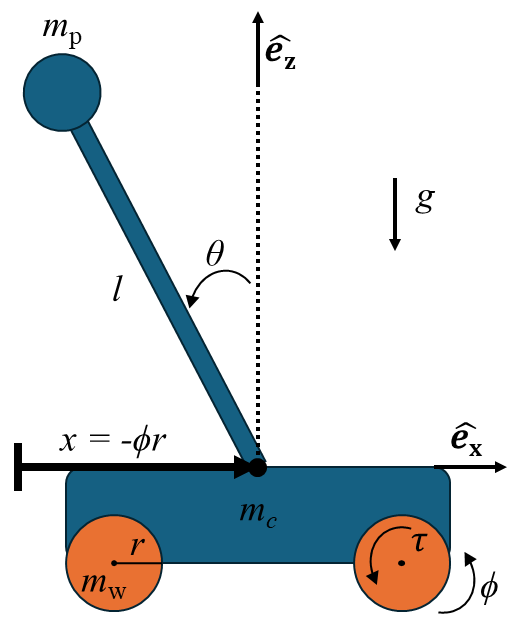

# System Dynamics and Equations of Motion
This is the model of the cart. There are two generalized coordinates: $\theta$ (the pendulum angle) and $\phi$ (the wheel angle). Because we assume that all the wheels are rolling without slipping, each wheel has the same angle. Further, the $x$ coordinate of the cart can be expressed in terms of the wheel angle and the radius of the wheels, $r$. Lastly, the input to the system is some torque, $\tau$, that is applied equally to all the wheels.

The first step in the Lagrangian mechanics approach is to calculate the total kinetic energy of the system and the total potential energy of the system with respect to the generalized coordinates and their derivatives. We can do this using the Python package Sympy.

In [1]:
# Import everything we need from SymPy
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the parameters of the system as constants:

In [2]:
# Constants of the system
mp = 1.0
mc = 6.0
mw = 1.0
l = 1.0
r = 0.25
g = 9.81

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [3]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

Now we will start to calculate the energies of the system. We can start by getting the kinetic energy of the mass on top of the rod. We can do this by:
1. Defining its position in terms of the generalized coordinates
2. Take the derivate of the position with respect to time to get the velocity
3. Calculate the kinetic energy from the velocity
4. Calculate the potential energy by observation

In [4]:
# Get the position of the mass in terms of phi and theta
pos = Matrix([-r*phi(t) - l*sin( theta(t) ),
              0.0,
              l*cos( theta(t) )])

In [5]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [6]:
# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

In [7]:
# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

Because the rod is assumed to be massless and have no inertia, we can move on the the energy of the cart. The cart does not change height, so its potential energy is automatically 0. This means all we have to do is calculate the kinetic energy.

In [8]:
# Get the position of the cart in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [9]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [10]:
# Get the kinetic energy of the cart from the velocity
cart_KE = 0.5 * mc * (vel.T @ vel)[0,0]

Next up, the wheels. Similarly, they have no potential energy, however they do have rotational energy. So we need to calculate both thier kinetic and rotational energy. Also, while calculating the position, we will ignore the constant offsets that each of the four wheels have. We can do this because constants disappear during differentiation.

In [11]:
# Get the position of the wheels in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [12]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [13]:
# Get the kinetic energy of all four wheels from the velocity
wheel_KE = 4.0 * (0.5 * mw * (vel.T @ vel)[0,0])

In [14]:
# Get the rotational kinetic energy of all four wheels
I = 0.5*mw*r**2
wheel_RE = 4.0*(I*diff(phi(t),t)**2)

Now we calculate the lagrangian of the system via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

In [15]:
# Get the lagrangian
L = (mass_KE + cart_KE + wheel_KE + wheel_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

System Lagrangian:


Finally, we get the equations of motion of the system via the formulas:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=\tau$$

In [16]:
# Get the first equation of motion
eq1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

In [17]:
# Get the second equation of motion
eq2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - tau(t)

This form of equations of motion is not very helpful to us right now, so next we will place them in standard form. A standard form system of ordinary differential equations satisfy the following requirements
* All equations are exactly first order ordinary differential equations
* Each equation only has exactly one time derivative variable in it
* Each equation has the form $\frac{d x}{dt} = f(x,y,z,...)$

Because the equations of motion above are second order, we need to apply a trick to place them in standard form. Namely, we introduce new variables that increase the number of equations while reducing the order of each equation. For example, let's introduce two new variables, $\omega_{\theta}$ and $\omega_{\phi}$ that satisfy the standard form ordinary differential equations:
$$\frac{d \theta}{dt} = \omega_{\theta}$$
$$\frac{d \phi}{dt} = \omega_{\phi}$$
Then, by taking the derivative of both sides, we see that
$$\frac{d^2 \theta}{d t^2} = \frac{d \omega_{\theta}}{dt}$$
$$\frac{d^2 \phi}{d t^2} = \frac{d \omega_{\phi}}{dt}$$
Let's make this change of variables to our equations of motion right now.

In [18]:
# Make the new functions for our change of variables
omega_theta = Function('omega_theta')
omega_phi = Function('omega_phi')

In [19]:
# Make the change of variables for equation 1
eq1 = eq1.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

In [20]:
# Repeat for equation 2
eq2 = eq2.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

The final step to place the equations in standard form is to ensure they have the form $\frac{d x}{dt} = f(x,y,z,...)$. We do this now.

In [21]:
# Solve the first two equations of motion for \dot{omega_theta} and \dot{omega_phi}
soln = solve([eq1, eq2],
             Derivative(omega_theta(t), t),
             Derivative(omega_phi(t), t))
soln = simplify(soln)

We now have a system of ordinary differential equations in standard from. Specifically, we have:
$$\frac{d \omega_{\theta}}{dt} = f_{\omega_{\theta}}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \omega_{\phi}}{dt} = f_{\omega_{\phi}}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \theta}{dt} = f_{\theta}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \phi}{dt} = f_{\phi}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$

Let's now combine the right hand side of this system into a single vector.

In [22]:
sys = Matrix([soln[Derivative(omega_theta(t), t)],
              soln[Derivative(omega_phi(t), t)],
              omega_theta(t),
              omega_phi(t)])
sys = simplify(sys)
N(sys, 3) # This rounds floating point number to 3 places and then prints to the screen

⎡           2                                                         ⎤
⎢10.0⋅ωₜₕₑₜₐ (t)⋅sin(2⋅θ(t)) + 80.0⋅τ(t)⋅cos(θ(t)) - 2.94e+3⋅sin(θ(t))⎥
⎢─────────────────────────────────────────────────────────────────────⎥
⎢                               2                                     ⎥
⎢                       20.0⋅cos (θ(t)) - 300.0                       ⎥
⎢                                                                     ⎥
⎢                  2                                                  ⎥
⎢    - 100.0⋅ωₜₕₑₜₐ (t)⋅sin(θ(t)) - 400.0⋅τ(t) + 491.0⋅sin(2⋅θ(t))    ⎥
⎢    ─────────────────────────────────────────────────────────────    ⎥
⎢                               2                                     ⎥
⎢                       25.0⋅cos (θ(t)) - 375.0                       ⎥
⎢                                                                     ⎥
⎢                              ωₜₕₑₜₐ(t)                              ⎥
⎢                                                               

This is our complete system model!

# System Linearization and State Space Form
To make our controller from this model, we first linearize the system about an equilibrium point. This will give us a new system of the form:
$$\frac{d \omega_{\theta}}{dt} \approx 
\frac{\partial f_{\omega_{\theta}}}{\partial \omega_{\theta}} \Bigr|_{e} \left( \omega_{\theta} - \omega_{\theta_{e}} \right) + 
\frac{\partial f_{\omega_{\theta}}}{\partial \omega_{\phi}} \Bigr|_{e} \left( \omega_{\phi} - \omega_{\phi{e}} \right) + 
\frac{\partial f_{\omega_{\theta}}}{\partial \theta} \Bigr|_{e} \left( \theta - \theta_{e} \right) + 
\frac{\partial f_{\omega_{\theta}}}{\partial \phi} \Bigr|_{e} \left( \phi - \phi_{e} \right) + 
\frac{\partial f_{\omega_{\theta}}}{\partial \tau} \Bigr|_{e} \left( \tau - \tau_{e} \right)$$
$$\frac{d \omega_{\phi}}{dt} \approx 
\frac{\partial f_{\omega_{\phi}}}{\partial \omega_{\theta}} \Bigr|_{e} \left( \omega_{\theta} - \omega_{\theta_{e}} \right) + 
\frac{\partial f_{\omega_{\phi}}}{\partial \omega_{\phi}} \Bigr|_{e} \left( \omega_{\phi} - \omega_{\phi{e}} \right) + 
\frac{\partial f_{\omega_{\phi}}}{\partial \theta} \Bigr|_{e} \left( \theta - \theta_{e} \right) + 
\frac{\partial f_{\omega_{\phi}}}{\partial \phi} \Bigr|_{e} \left( \phi - \phi_{e} \right) + 
\frac{\partial f_{\omega_{\phi}}}{\partial \tau} \Bigr|_{e} \left( \tau - \tau_{e} \right)$$
$$\frac{d \theta}{dt} \approx 
\frac{\partial f_{\theta}}{\partial \omega_{\theta}} \Bigr|_{e} \left( \omega_{\theta} - \omega_{\theta_{e}} \right) + 
\frac{\partial f_{\theta}}{\partial \omega_{\phi}} \Bigr|_{e} \left( \omega_{\phi} - \omega_{\phi{e}} \right) + 
\frac{\partial f_{\theta}}{\partial \theta} \Bigr|_{e} \left( \theta - \theta_{e} \right) + 
\frac{\partial f_{\theta}}{\partial \phi} \Bigr|_{e} \left( \phi - \phi_{e} \right) + 
\frac{\partial f_{\theta}}{\partial \tau} \Bigr|_{e} \left( \tau - \tau_{e} \right)$$
$$\frac{d \phi}{dt} \approx
\frac{\partial f_{\phi}}{\partial \omega_{\theta}} \Bigr|_{e} \left( \omega_{\theta} - \omega_{\theta_{e}} \right) + 
\frac{\partial f_{\phi}}{\partial \omega_{\phi}} \Bigr|_{e} \left( \omega_{\phi} - \omega_{\phi{e}} \right) + 
\frac{\partial f_{\phi}}{\partial \theta} \Bigr|_{e} \left( \theta - \theta_{e} \right) + 
\frac{\partial f_{\phi}}{\partial \phi} \Bigr|_{e} \left( \phi - \phi_{e} \right) + 
\frac{\partial f_{\phi}}{\partial \tau} \Bigr|_{e} \left( \tau - \tau_{e} \right)$$

It is customary to call the vector
$$
{\begin{bmatrix}
\omega_{\theta} - \omega_{\theta_{e}} \\
\omega_{\phi} - \omega_{\phi_{e}} \\
\theta - \theta_{e} \\       
\phi - \phi_{e}
\end{bmatrix}}
$$
the **state** vector and give it the symbol ***x***. Then, the elements in ***x*** are refered to as **states**. Similarly, 
$$
{\begin{bmatrix}
\tau-\tau_{e}
\end{bmatrix}}
$$
is called the **input** vector and given the symbol ***u***. The elements in ***u*** are refered to as **inputs**. Using these vectors, we can rewrite the linearized system in the form
$$ \dot{x}=Ax+Bu, $$
which is commonly called state space form and is useful for many kinds of controller design.

Let's linearize the system and place it in state space form now:

In [23]:
# Choose an equilibrium point
omega_theta_e = 0.0
omega_phi_e = 0.0
theta_e = 0.0
phi_e = 0.0
tau_e = 0.0

# Make sure that our equilibrium point is valid
eq_pt = sys.subs({omega_theta(t) : omega_theta_e, 
                  omega_phi(t)   : omega_phi_e,
                  theta(t)       : theta_e,
                  phi(t)         : phi_e,
                  tau(t)         : tau_e})

# Print and make sure the equations are all 0 (this is the definition of an equilibrium point)
eq_pt

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [24]:
# Take the state jacobian (all the partial derivatives of state variables) of the dynamics vector
x = Matrix([omega_theta(t),
            omega_phi(t),
            theta(t),
            phi(t)])
A_jac = sys.jacobian(x)

# Evaluate the state jacobian at the equilibrium point
A = A_jac.subs({omega_theta(t) : omega_theta_e, 
                omega_phi(t)   : omega_phi_e,
                theta(t)       : theta_e,
                phi(t)         : phi_e,
                tau(t)         : tau_e})

# Print out our A matrix
print("The A matrix:")
N(A, 3)  # This rounds floating point number to 3 places and then prints to the screen

The A matrix:


⎡ 0    0   10.5  0⎤
⎢                 ⎥
⎢ 0    0   -2.8  0⎥
⎢                 ⎥
⎢1.0   0    0    0⎥
⎢                 ⎥
⎣ 0   1.0   0    0⎦

In [25]:
# Take the input jacobian (all the partial derivatives of input variables) of the dynamics vector
u = Matrix([tau(t)])
B_jac = sys.jacobian(u)

# Evaluate the input jacobian at the equilibrium point
B = B_jac.subs({omega_theta(t) : omega_theta_e, 
                omega_phi(t)   : omega_phi_e,
                theta(t)       : theta_e,
                phi(t)         : phi_e,
                tau(t)         : tau_e})

# Print out our B matrix
print("The B matrix:")
N(B, 3)  # This rounds floating point number to 3 places and then prints to the screen

The B matrix:


⎡-0.286⎤
⎢      ⎥
⎢ 1.14 ⎥
⎢      ⎥
⎢  0   ⎥
⎢      ⎥
⎣  0   ⎦

# Gain Selection and Controller Design
Finally, we build an optimal controller from the solution to the linear quadratic regulator. This can be done automatically from the controls toolbox.

In [26]:
import control
import numpy as np

To begin, let's check the controllability of our system. This is done by first calculating the controllability matrix, then ensuring it is full rank. Given our state space form:
$$ \dot{x}=Ax+Bu, $$
the controllability matrix is calculated by
$$ W = \left[ B \space | \space AB \space | \space AAB \space | \space ... \space | \space A^{n-1}B \right], $$
where 
$$ A \in \mathbb{R}^{n \times n}, \space B \in \mathbb{R}^{n \times m}.  $$

In this problem, $ n = 4$ and $ m = 1 $, so the controllability matrix is given by
$$ W = \left[ B \space | \space AB \space | \space AAB \space | \space AAAB \right]. $$

In [27]:
# Calculate the controllability matrix
W = Matrix()
W = W.col_insert(0, B)
W = W.col_insert(1, A@B)
W = W.col_insert(2, A@A@B)
W = W.col_insert(3, A@A@A@B)

# Print out our controllability matrix
print("The controllability matrix:")
N(W, 3)  # This rounds floating point number to 3 places and then prints to the screen

The controllability matrix:


⎡-0.286    0     -3.0     0  ⎤
⎢                            ⎥
⎢ 1.14     0     0.801    0  ⎥
⎢                            ⎥
⎢  0     -0.286    0    -3.0 ⎥
⎢                            ⎥
⎣  0      1.14     0    0.801⎦

Now, we must ensure that $W$ has full rank. This means that the rank of $W$ is exactly equal to the number of columns of $W$. When this is true, it means the null space of $W$ is $\{ 0 \}$.

In [28]:
W.rank()

The rank of $W$ is 4, so that means the system is controllable. This means we can continue with designing the controller.

For LQR controller design, we need two things:
* the system in state space form, and
* cost matrices.
The cost matrices define the infinite horizon, continuous time optimal control problem that the LQR solves. This optimal control problem has the form:
$$ 
\begin{equation}
\begin{aligned}
& \min_{u \left( t \right) } & & \int_{0}^{\infty} x^{T}\left(t\right) Q x \left(t\right) + u^{T}\left(t\right) R u \left(t\right)\, dt \\
& \textrm{subject to} & & \dot{x} = Ax+Bu, \quad x(0) = x_{0}\\
\end{aligned}
\end{equation}
$$

Let's pick these cost matrices, $Q$ and $R$.

In [29]:
# Define our state and input costs:
Q = np.eye(4)
Q[0,0] = 1.
Q[1,1] = 1.
Q[2,2] = 1.
Q[3,3] = 1.
R = np.eye(1)
R[0,0] = 10.

Next we can solve the LQR problem using the control toolbox to get our optimal control gains.

In [30]:
# Get the control gains
K, X, E = control.lqr(A, B, Q, R)

Now we build the controller itself. The controller will take measured states, gains, and equilibrium states as arguments and return the calculated input(s). This is done by the optimal input equation:
$$ u(t) = -K x(t). $$

In [31]:
def controller(**kwargs):
    # Gather the states measured via sensors
    omega_theta = kwargs['pendulum_rate']
    omega_phi = kwargs['wheel_rate']
    theta = kwargs['pendulum_angle']
    phi = kwargs['wheel_angle']

    # Gather the equilibrium state values
    omega_theta_e = kwargs['equil_pendulum_rate']
    omega_phi_e = kwargs['equil_wheel_rate']
    theta_e = kwargs['equil_pendulum_angle']
    phi_e = kwargs['equil_wheel_angle']
    tau_e = kwargs['equil_torque']

    # Gather the gains
    K = kwargs['gains']

    # Build the state vector
    x = np.array([omega_theta - omega_theta_e,
                 omega_phi - omega_phi_e,
                 theta - theta_e,
                 phi - phi_e])

    # Apply the gains using the formula u = -Kx
    u = -K@x

    # Convert the input vector to real inputs
    tau = u[0] + tau_e

    # Limit the torque to between -5 and 5 Nm
    if tau > 5.0:
        tau = 5.0
    elif tau < -5.0:
        tau = -5.0

    # Return the controller calculated torque
    return tau

For fun, we can also make a controller where you select the torque via keyboard inputs. This is done below:

In [32]:
def manual_controller(**kwargs):
    # Get the simulator object so we can use it to detect key presses
    sim = kwargs['sim']

    # Detect key presses and set torque accordingly 
    if sim.is_pressed("shift+d"):
        torque = 5.0
    elif sim.is_pressed("shift+a"):
        torque = -5.0
    elif sim.is_pressed("d"):
        torque = 1.0
    elif sim.is_pressed("a"):
        torque = -1.0
    else:
        torque = 0.0

    # Return the manually set torque
    return torque

# Testing the Controller Via Simulation

In [33]:
# Import condynsate. This package is used to simulate, render, and plot dynamic systems
import condynsate

First create an instanace of a simulator. Running this command will both create a simulator and open a visualization window in your default internet browser.

In [34]:
# Create an instance of the simulator with visualization and animation
sim = condynsate.Simulator(visualization=True, # Visualization is the process of rendering your dynamic system in 3D
                           animation=True,     # Animation is the process of live plotting data from the simulation
                           animation_fr=15.    # This parameter is the frame rate of the animator (plots)
                          )

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Next, load the ground, walls, and cart URDF files. As we load each URDF file, it will automatically appear in your visualization window.

In [35]:
# Load the ground as a static object
ground_obj = sim.load_urdf(urdf_path='./cart_vis/plane.urdf',
                            position=[0., 0., 0.],
                            wxyz_quaternion=[1., 0., 0., 0],
                            fixed=True,
                            update_vis=False)

In [36]:
# Load the left wall as a static object
left_wall_obj = sim.load_urdf(urdf_path='./cart_vis/plane.urdf',
                              tex_path='./cart_vis/concrete.png',
                              position=[0., -5., 0.],
                              roll=-np.pi/2.,
                              fixed=True,
                              update_vis=False)

In [37]:
# Load the right wall as a static object
right_wall_obj = sim.load_urdf(urdf_path='./cart_vis/plane.urdf',
                               tex_path='./cart_vis/concrete.png',
                               position=[0., 5., 0.],
                               roll=np.pi/2.,
                               fixed=True,
                               update_vis=False)

In [38]:
# Load the cart with the inverted pendulum
cart_obj = sim.load_urdf(urdf_path='./cart_vis/cart.urdf',
                            position=[0., 0., 0.25],
                            yaw=np.pi/2,
                            fixed=False,
                            update_vis=True)

Now we set up the animator. In this case, we want two subplots, each of the line chart type. The first subplot will contain the pendulum angle and wheel angle data vs time, and the second plot will contain the torque versus time data.

In [39]:
# This defines the first subplot.
# This subplot will plot the wheel angle and the pendulum angle
plot1, artists1 = sim.add_subplot(n_artists=2,                             # How many total things that are going to drawn to the subplot (2 line charts)
                                  subplot_type='line',                     # What type of subplot this is going to be
                                  title="Angles vs Time",                  # The title of our subplot
                                  x_label="Time [Seconds]",                # The label to give the x axis
                                  y_label="Angles [Deg / Rad]",            # The label to give the y axis
                                  colors=["m", "c"],                       # The colors of each line
                                  line_widths=[2.5, 2.5],                  # The width (thickness) of each line
                                  line_styles=["-", "-"],                  # The style of each line (solid and dotted)
                                  labels=["Pendulum [Deg]", "Wheel [Rad]"] # The name of each line in the subplot
                                 )

In [40]:
# This subplot will track the torque applied to the wheels
plot2, artists2 = sim.add_subplot(n_artists=1,
                                  subplot_type='line',
                                  title="Torque vs Time",
                                  x_label="Time [Seconds]",
                                  y_label="Torque [Nm]",
                                  colors=["k"],
                                  line_widths=[2.5],
                                  y_lim=[-5.0, 5.0]
                                 )

After adding all the subplots that we want, we open the animator GUI. This will open a new window that shows the plot that you just defined.

In [41]:
sim.open_animator_gui()

Before running the simulation, we can set some initial pendulum angle and rate here. This can help us test how well our controller works subject to different initial conditions.

In [42]:
# Give the pendulum an initial angle and speed
initial_angle = 0.25
initial_speed = 0.0

# Set the initial angle
sim.set_joint_position(urdf_obj=cart_obj,            # The urdf id of the cart that was generated above
                        joint_name='chassis_to_arm', # The name of the joint whose angle is being set
                        position=initial_angle,      # The initial angle that we set in radians
                        initial_cond=True            # The joint position is an initial condition and will be reset to this when tab is pressed
                      )

# Set the initial velocity
sim.set_joint_velocity(urdf_obj=cart_obj,            # The urdf id of the cart that was generated above
                        joint_name='chassis_to_arm', # The name of the joint whose angle is being set
                        velocity=initial_speed,      # The initial velocity that we set in radians per second
                        initial_cond=True            # The joint velocity is an initial condition and will be reset to this when tab is pressed
                      )

Now we can run our simulation. To start the simulation, press **enter** on your keyboard. To reset the simulation, press **tab** on your keyboard. To pause the simulation, press **space** on your keyboard. When you're done, make sure to press **esc** to stop the simulation.

In [43]:
# Before we run the simulation, we wait for the user to press enter on their keyboard.
# By calling this function, we can keep the animator GUI responsive while waiting for IO.
sim.await_keypress(key="enter")

# Run the simulation
while(not sim.is_done):
    ###########################################################################
    # SENSOR
    # Use a sensor to collect the pendulum angle and rate
    pendulum_state = sim.get_joint_state(urdf_obj=cart_obj,
                                    joint_name='chassis_to_arm')
    pendulum_angle = pendulum_state['position']
    pendulum_rate = pendulum_state['velocity']
    
    # Use a sensor to collect the angles and rates of each wheel
    wheel1_state = sim.get_joint_state(urdf_obj=cart_obj,
                                       joint_name='chassis_to_wheel_1')
    wheel2_state = sim.get_joint_state(urdf_obj=cart_obj,
                                       joint_name='chassis_to_wheel_2')
    wheel3_state = sim.get_joint_state(urdf_obj=cart_obj,
                                       joint_name='chassis_to_wheel_3')
    wheel4_state = sim.get_joint_state(urdf_obj=cart_obj,
                                       joint_name='chassis_to_wheel_4')
    
    # Calculate the average wheel angle and velocity
    wheel_angle = 0.25*(wheel1_state['position']+
                       wheel2_state['position']+
                       wheel3_state['position']+
                       wheel4_state['position'])
    wheel_rate = 0.25*(wheel1_state['velocity']+
                       wheel2_state['velocity']+
                       wheel3_state['velocity']+
                       wheel4_state['velocity'])
    
    ###########################################################################
    # CONTROLLER
    # This is the section where you apply your controller.
    torque = controller(pendulum_angle=pendulum_angle,
                        pendulum_rate=pendulum_rate,
                        wheel_angle=wheel_angle,
                        wheel_rate=wheel_rate,
                        equil_pendulum_angle=0.0,
                        equil_pendulum_rate=0.0,
                        equil_wheel_angle=0.0,
                        equil_wheel_rate=0.0,
                        equil_torque=0.0,
                        gains=K
                       )

    # We can also apply the manual controller if we want
    #torque = manual_controller(sim=sim)
    
    ###########################################################################
    # ACTUATOR
    # Apply one quater of the controller calculated torque to each of the four the wheels.
    sim.set_joint_torque(urdf_obj=cart_obj,                # The urdf id of the cart that was generated above
                          joint_name='chassis_to_wheel_1', # The name of the joint to which the torque is applied
                          torque=0.25*torque,              # The amount of torque we apply
                          show_arrow=True,                 # This indicates that we visualize the torque with an arrow
                          arrow_scale=0.25,                # The size of the arrow
                          arrow_offset=0.025               # The amount the arrow is offset from the center of the axle motor 
                        )
    sim.set_joint_torque(urdf_obj=cart_obj,
                          joint_name='chassis_to_wheel_2',
                          torque=0.25*torque,
                          show_arrow=True,
                          arrow_scale=0.25,
                          arrow_offset=0.025
                        )
    sim.set_joint_torque(urdf_obj=cart_obj,
                          joint_name='chassis_to_wheel_3',
                          torque=0.25*torque,
                          show_arrow=True,
                          arrow_scale=0.25,
                          arrow_offset=-0.025
                        )
    sim.set_joint_torque(urdf_obj=cart_obj,
                          joint_name='chassis_to_wheel_4',
                          torque=0.25*torque,
                          show_arrow=True,
                          arrow_scale=0.25,
                          arrow_offset=-0.025
                        )
    
    ###########################################################################
    # UPDATE THE PLOTS
    # This is how we add data points to the animator
    # Plot the pendulum angle, wheel angle, and torque
    sim.add_subplot_point(subplot_index=plot1,      # The subplot id on which we plot the angle vs time
                          artist_index=artists1[0], # The line id to which we send the angle vs time data point
                          x=sim.time,               # The x coordinate of the data point we send (current time)
                          y=pendulum_angle          # The y coordinate of the data point we send (current angle of the pendulum)
                         )
    sim.add_subplot_point(subplot_index=plot1,
                          artist_index=artists1[1],
                          x=sim.time,
                          y=wheel_angle
                         )
    sim.add_subplot_point(subplot_index=plot2,
                          artist_index=artists2[0],
                          x=sim.time,
                          y=torque
                         )
    
    ###########################################################################
    # STEP THE SIMULATION
    sim.step(real_time=True,   # We want our simulation to run in real time (or as close as possible)
              update_vis=True, # We want to update the visualizer each time we step the physics
              update_ani=True  # We want to update the animator each time we step the physics
            )

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS TAB TO RESET SIMULATION.
CONTINUING...
Termination command detected. Terminating keyboard listener. Goodbye
